# Detection for SM-SIF images

In [1]:
import numpy as np
# Set up matplotlib and use a nicer set of plot parameters
%config InlineBackend.rc = {}
import matplotlib
matplotlib.rc_file("../../templates/matplotlibrc")
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from astropy.io import fits
import astroscrappy

In [3]:
from matplotlib.colors import LogNorm

In [4]:
import scipy.ndimage as ndimage

In [5]:
from extraction_sm import *

Grab one dataset

In [21]:
#sourcefile=("../../datasets/sif_fits/2014-01-03/SIF_PROCESSING_CCD_ROW_1_SM1_OBMT_START_5520130998393550_CDP_NONE.fits")
sourcefile=("../../datasets/sif_fits/2015-04-03/SIF_PROCESSING_CCD_ROW_3_SM1_OBMT_START_45028212999616700_CDP_NONE.fits")
#sourcefile=("../../datasets/sif_fits/2015-07-03/SIF_PROCESSING_CCD_ROW_7_SM1_OBMT_START_52953386000234300_CDP_NONE.fits")
#sourcefile=("../../datasets/sif_fits/2016-01-29/SIF_PROCESSING_CCD_ROW_3_SM2_OBMT_START_71037995998161500_CDP_NONE.fits")
#sourcefile=("../../datasets/sif_fits/2017-07-02/SIF_PROCESSING_CCD_ROW_1_SM2_OBMT_START_116035731998906300_CDP_NONE.fits")
#sourcefile=("../../datasets/sif_fits/2017-09-11/SIF_PROCESSING_CCD_ROW_1_SM1_OBMT_START_122099768999236700_CDP_NONE.fits")

# LMC
#sourcefile=("../../datasets/sif_fits/2016-07-27/SIF_PROCESSING_CCD_ROW_6_SM2_OBMT_START_86607646999502300_CDP_NONE.fits")
# Galaxy
#sourcefile=("../../datasets/sif_fits/2014-12-25/SIF_PROCESSING_CCD_ROW_5_SM1_OBMT_START_36489817999936700_CDP_NONE.fits")
# Jupiter (bright!)
#sourcefile=("../../datasets/sif_fits/2014-11-21/SIF_PROCESSING_CCD_ROW_7_SM1_OBMT_START_33618388000607900_CDP_NONE.fits")


(source,gain,bias,readnoise,fov,row,tstart,tstop) = sm_get_image(sourcefile, "../../datasets/sm_bias/sm_calibdat.fits")

(2542, 990)


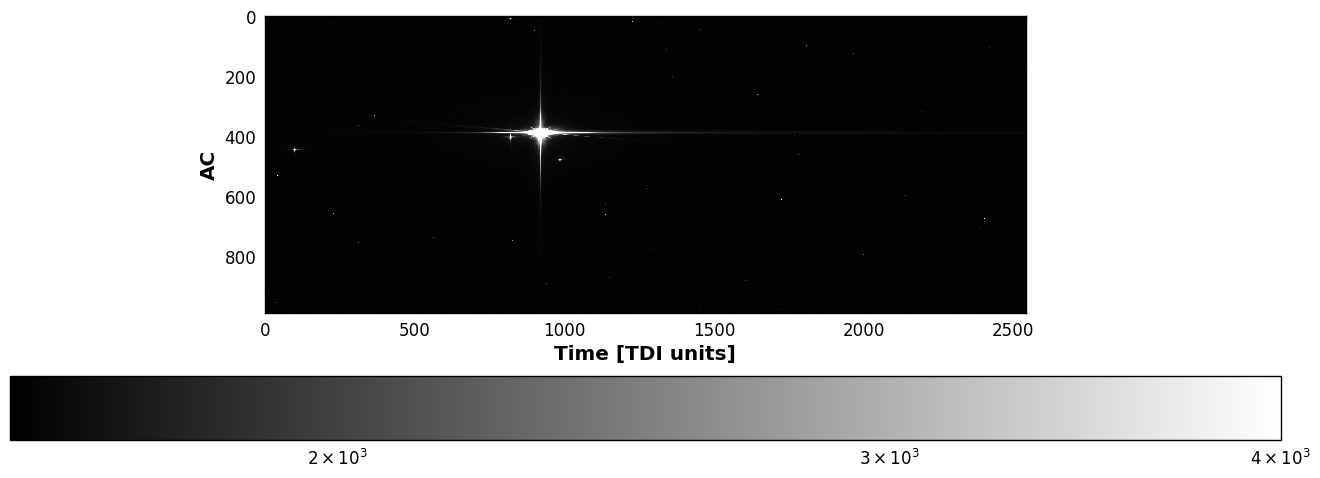

In [22]:
print(source.shape)

image=np.flip(np.rot90(source,1),0) # this should follow the normal gaia convention
plt.xlabel('Time [TDI units]')
plt.ylabel('AC')
plt.imshow(image, cmap='gray', norm=LogNorm(),vmax=4e3)
plt.colorbar(orientation="horizontal")
plt.gcf().set_size_inches(30.5, 5.5)
plt.grid(False)

Masked  0.48% of pixels


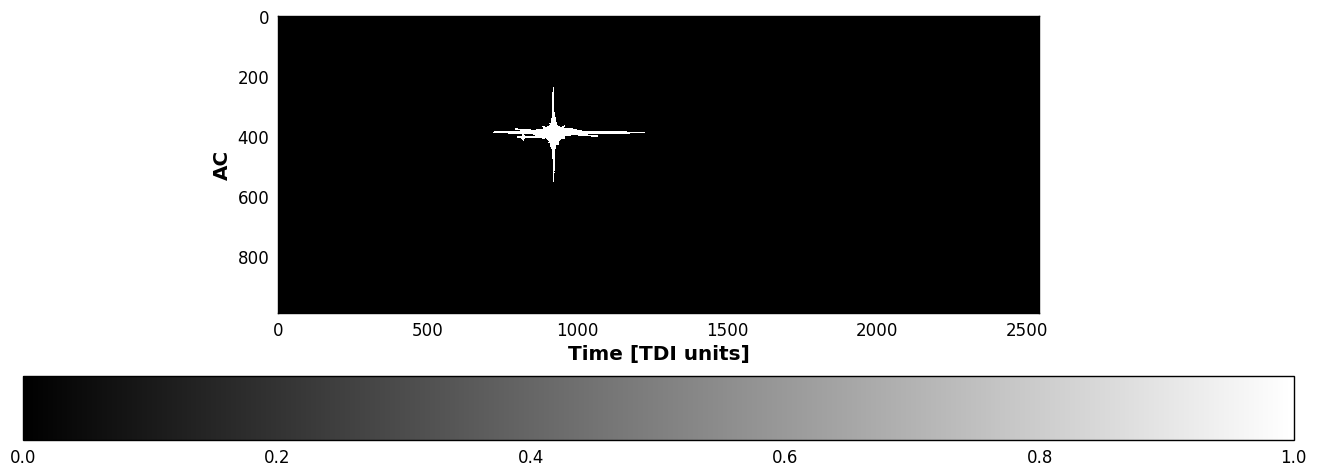

In [23]:
# generate the star mask

starmask = sm_starmask(source, 2000)
#starmask = sm_starmask_box(source,60000,buffer_row=2,buffer_col=1)

# out of curiosity:

print("Masked {:5.2f}% of pixels".format(100*np.sum(starmask)/source.shape[0]/source.shape[1]))

image=np.flip(np.rot90(starmask,1),0) # this should follow the normal gaia convention
plt.xlabel('Time [TDI units]')
plt.ylabel('AC')
plt.imshow(image, cmap='gray')
plt.colorbar(orientation="horizontal")
plt.gcf().set_size_inches(30.5, 5.5)
plt.grid(False)

In [24]:
from scipy.ndimage.measurements import label, find_objects
    
imbias = np.subtract(source, bias)

# apply scrappy
(mask,clean) = astroscrappy.detect_cosmics(imbias, gain=gain, verbose=True, inmask=starmask, 
                                           satlevel=65535, readnoise=readnoise, sepmed=False, 
                                           cleantype='meanmask', fsmode='median',
                                           sigclip=10, sigfrac=0.3, objlim=10.0)
# labelling
(labels, ntracks) = label(mask, structure=(np.ones((3,3))))

# object extraction
evtlocs = find_objects(labels)

# calculate the cosmics
cosmics = ((imbias)*gain - clean)*mask

Starting 4 L.A.Cosmic iterations
Iteration 1:
590 cosmic pixels this iteration
Iteration 2:
12 cosmic pixels this iteration
Iteration 3:
2 cosmic pixels this iteration
Iteration 4:
0 cosmic pixels this iteration


Okay, it seems that several cosmics have been detected.

0.0 108795.257196


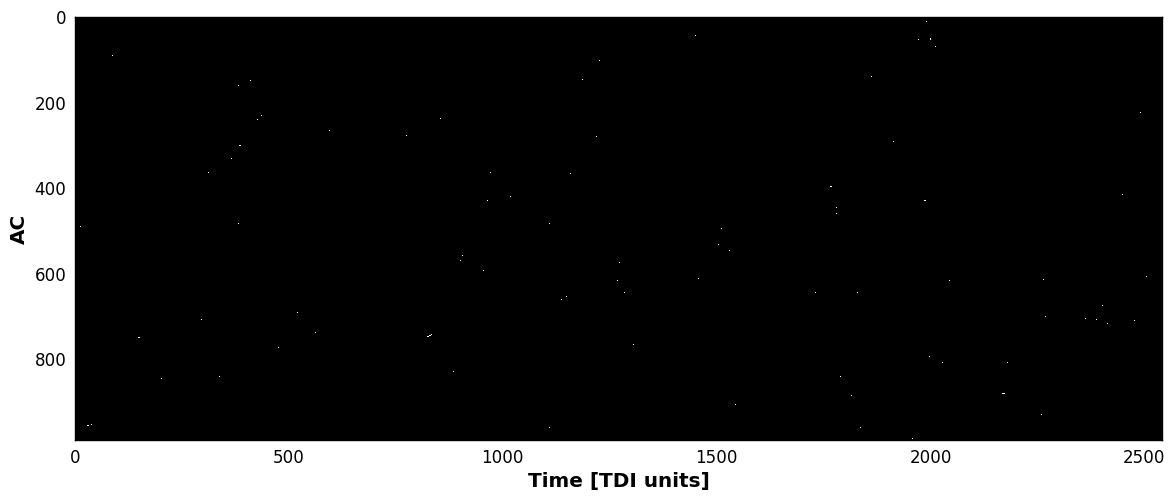

In [25]:
image=np.copy(np.flip(np.rot90(cosmics,1),0)) # this should follow the normal gaia convention
plt.xlabel('Time [TDI units]')
plt.ylabel('AC')

# the mask
image[image>0]=1
image[image<0]=0

plt.imshow(image, cmap='gray')
plt.gcf().set_size_inches(30.5, 5.5)

plt.grid(False)

print(np.min(cosmics), np.max(cosmics))

In [26]:
ntracks = len(evtlocs)
print("Number of events:", ntracks)

Number of events: 215


# Energies

In [27]:
# Extract track electron count

events_e = np.zeros(ntracks)

for ii in range(ntracks):
    events_e[ii] = np.sum(cosmics[evtlocs[ii]])

Min: 151.164938927
Max: 213943.318442


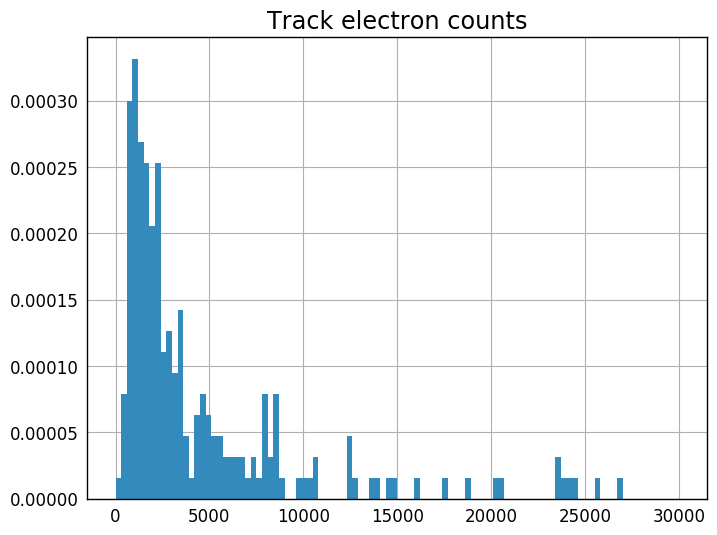

In [28]:
#ehist = plt.hist(events_e,1000,log=True)
ehist = plt.hist(events_e,100,range=(0,30000),normed=True) # cut off the maximum energies - I want a comparison with
                                              # the simulator validation presentation
plt.title("Track electron counts")
print('Min:',np.min(events_e))
print('Max:',np.max(events_e))

Interesting. Previous extraction for simulator validations of SM data (their slide 53) shows a similar distribution.

# Error estimation

Critical question: What is the error?

First estimate:

The uncertainty of the median is below the poisson uncertainty of the bkg

-> given that, how relevant is the former?

In [60]:
# calculate the error of the mean mask 

err_mean = np.zeros(source.shape)

# let's try a more efficient algorithm
(xmax, ymax) = source.shape
totmask = starmask+mask    # masked pixels, including stars
totmask[totmask==2]=1
unmasked = (imbias)*gain * (1-totmask)

rad = 2   # i.e. 2 for a 5x5 filter

# I need to count the number of unmasked pixels in the filter and
# the sum of unmasked pixel values in the filter
# This can be done very easily using convolution!

from scipy.signal import convolve2d
kernel = np.ones((2*rad+1,2*rad+1))

N_unm = convolve2d(1-totmask, kernel, mode="same", boundary="fill", fillvalue=0)
N_unm[N_unm==0]=1            # we'll be dividing by this later - this stops errors

var_mean = convolve2d(unmasked, kernel, mode="same", boundary="fill", fillvalue=0) # sum up everything around
var_mean = (readnoise*readnoise + var_mean/N_unm)/N_unm                            # from error propagation

err_mean = np.sqrt(var_mean + readnoise*readnoise + gain*imbias)              # total error
# note: we only need to use errors in the MASKED region, since everything else
#       was never replaced!
# (Theoretically we didn't even need to calculate it there, but convolution is very fast)

In [61]:
# Extract track electron count error

err_tracks = err_mean*mask
err_e = np.zeros(ntracks)

for ii in range(ntracks):
    err_e[ii] = np.sqrt(np.sum(err_tracks[evtlocs[ii]]**2))

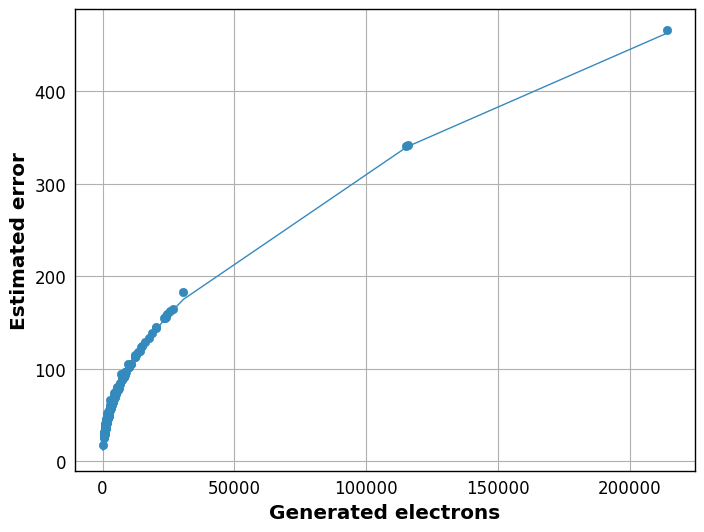

In [62]:
plt.scatter(events_e, err_e)
plt.plot(np.sort(events_e), np.sqrt(np.sort(events_e)))
plt.ylabel("Estimated error")
plt.xlabel("Generated electrons")

Looks fairly Poissonian - background plays little role, except in long cosmics

Minimum SNR: 8.68702127531


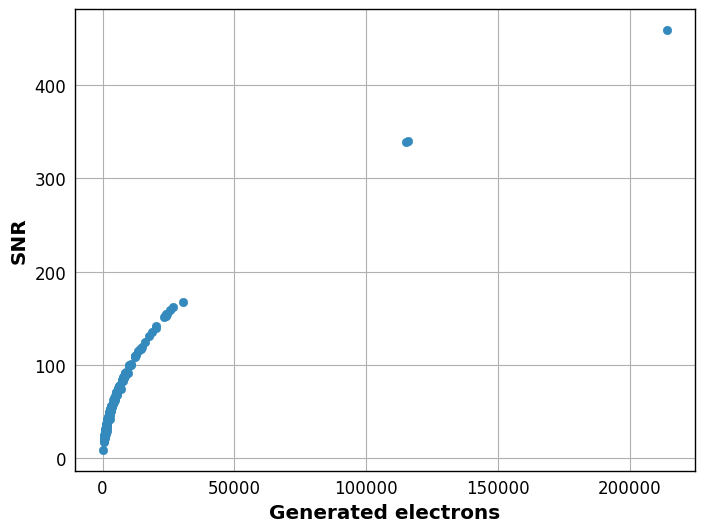

In [63]:
plt.scatter(events_e, events_e/err_e)
plt.ylabel("SNR")
plt.xlabel("Generated electrons")

print("Minimum SNR:", np.min(events_e/err_e))

(NOTE: This looks pretty much identical to the plot above, but that makes sense: N/sqrt(N) = sqrt(N)

# Track lengths

In [64]:
# Extract track lengths. We can use the slices for that

lengths = np.zeros(ntracks)
lx = np.zeros(ntracks)
ly = np.zeros(ntracks)

covered = 0   # amount of cosmic pixels

for ii in range(ntracks):
    # unit: \mu m
    dx = evtlocs[ii][0].stop-evtlocs[ii][0].start
    dy = evtlocs[ii][1].stop-evtlocs[ii][1].start

    lx[ii] = (dx-1)*20               # to roughly account for the binning
    ly[ii] = (dy-1)*60              # need to subtract 1, since single pixel cosmics would then have
                                     # a length of sqrt(2)
    covered += dx*dy

lengths = np.sqrt(lx**2 + ly**2)
#lhist = plt.hist(lengths,30)
#plt.title("Track Lengths")

In [65]:
# say we save this in uint16, that would be

print("file size:", covered*2, "bytes")
print("Covered fraction of image:", covered/source.shape[0]/source.shape[1]*100, "%")

file size: 1596 bytes
Covered fraction of image: 0.031709701261235484 %


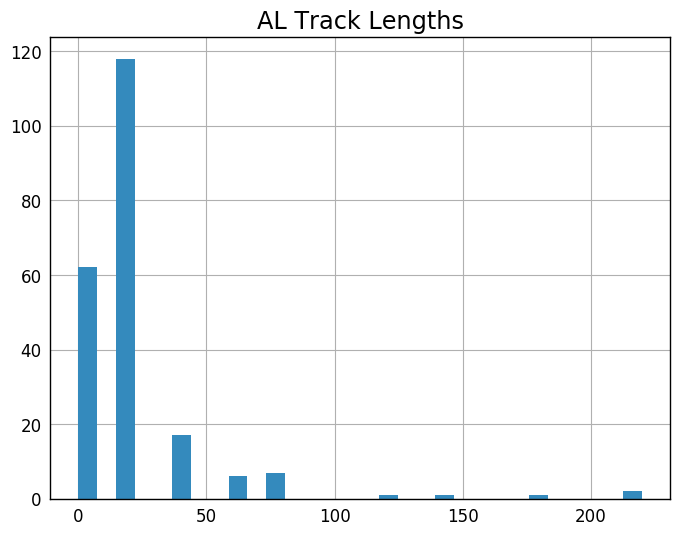

In [66]:
xhist = plt.hist(lx,30)
plt.title("AL Track Lengths")

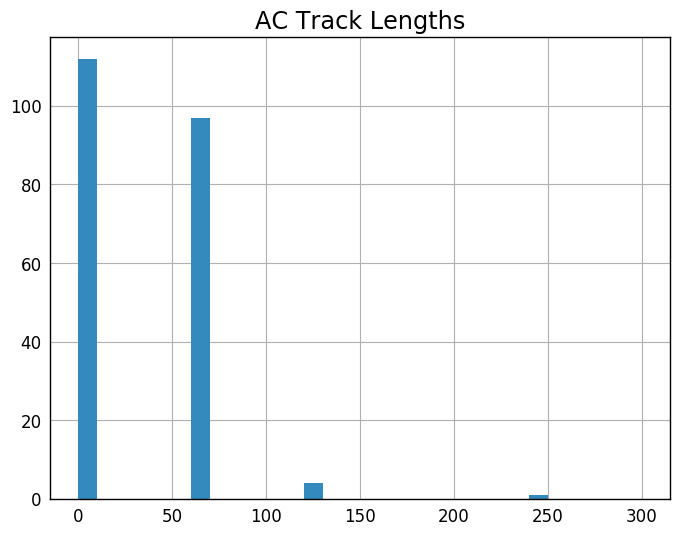

In [67]:
yhist = plt.hist(ly,30,range=(0,300))
plt.title("AC Track Lengths")

Now then, can we estimate the angles of our cosmics from that?

We define theta = 0 if we are along AL

In [68]:
theta = np.zeros(lx.shape)

nonzero = np.logical_and(lx!=0, ly!=0)
theta[nonzero] = np.arctan(ly[nonzero]/lx[nonzero])*180/np.pi

theta[lx==0] = 90  # 90
theta[ly==0] = 0  # 0
theta[np.logical_and(lx==0, ly==0)] = 5000  # ignore for now

Let's figure out the cosmic orientation

In [69]:
# if the UPPER LEFT CORNER of the event has a cosmic, it faces downwards
# this only works for cosmics that have angles not 0 or 90 deg
for ii in range(len(lx)):
    if (lx*ly)[ii]!=0:
        if mask[evtlocs[ii]][0,0]==1:
            theta[ii] *= -1

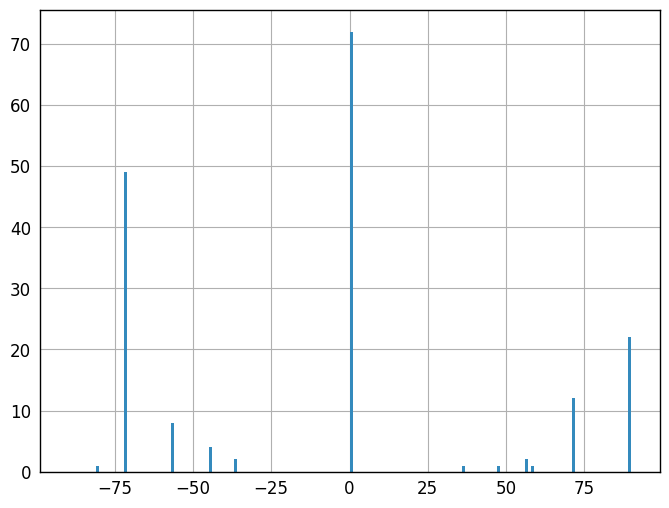

In [70]:
thist = plt.hist(theta,180,range=(-90,90))

In [71]:
print(np.arctan(60./20)*180/np.pi)

71.5650511771


Right, so the peak at about 71 degrees is just the largest population of AL lengths and all the non-zero ACs

I suppose the problem here would be that our angular resolution is a mess. A simulation to determine our angular "effective area" (meaning how biased we are for certain angles) may be good.

# What is our limiting resolution anyway?

In [85]:
print("Maximum noise:", np.max(err_mean[starmask==0]), "e-")
print("Mean noise:", np.mean(err_mean[starmask==0]), "e-")

Maximum noise: 480.852348959 e-
Mean noise: 11.8560160607 e-


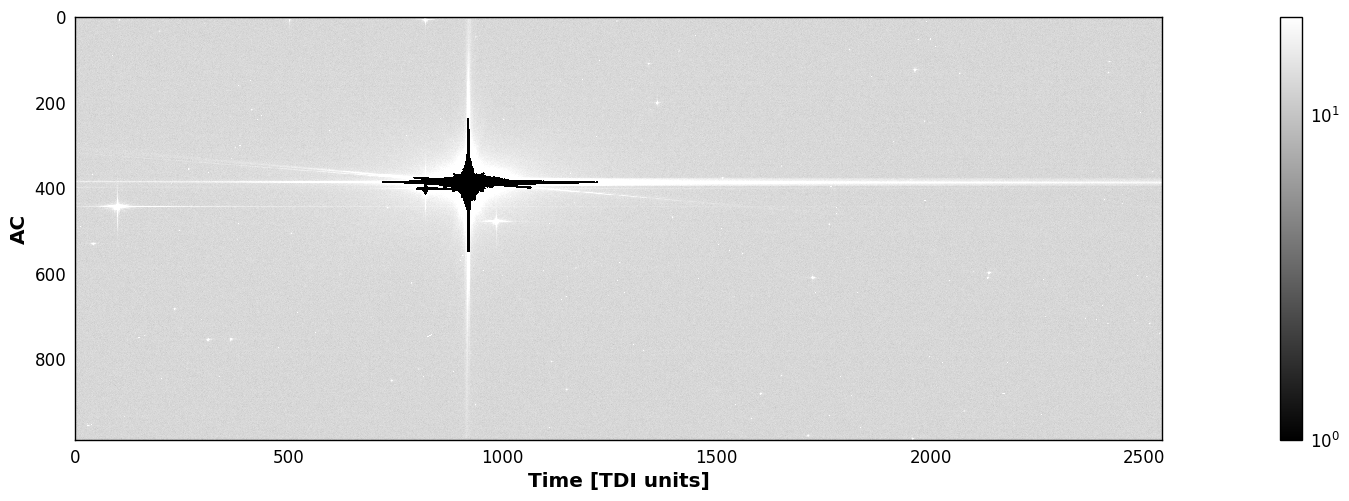

In [86]:
image=np.copy(np.flip(np.rot90(err_mean*(1-starmask)+1,1),0)) # this should follow the normal gaia convention
plt.xlabel('Time [TDI units]')
plt.ylabel('AC')

plt.imshow(image, cmap='gray',norm=LogNorm(),vmax=20)
plt.colorbar()
plt.gcf().set_size_inches(30.5, 5.5)
plt.grid(False)
